In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import matplotlib.patheffects as pe
import warnings
from scipy import sparse
from scipy import stats
import pickle
import matplotlib.patches as patches
from PIL import Image
import math
sc.settings.set_figure_params(dpi=160, facecolor='white')

In [2]:
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import textwrap

In [5]:
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams.update({'axes.labelsize' : 16}) 

In [6]:
biological_types = ["1_W3L1",
                    "2_W3D1",
                    "3_F-mini-ON",
                    "4_F-mini-OFF",
                    "5_J-RGC",
                    "6_W3B",
                    "7_Novel",
                    "8_Novel",
                    "9_Tbr1-Novel",
                    "10_ooDSGC",
                    "11_Novel",
                    "12_N-ooDSGC",
                    "13_W3L2",
                    "14_Novel",
                    "15_Novel",
                    "16_D/V-ooDSGC",
                    "17_Tbr1-S1",
                    "18_Novel",
                    "19_Novel",
                    "20_Novel",
                    "21_Tbr1-S2",
                    "22_MX",
                    "23_W3D2",
                    "24_ooDSGC",
                    "25_Novel",
                    "26_Novel",
                    "27_Novel",
                    "28_F-midi-OFF",
                    "29_Novel",
                    "30_W3D3",
                    "31_M2",
                    "32_F-Novel",
                    "33_M1",
                    "34_Novel",
                    "35_Novel",
                    "36_Novel",
                    "37_Novel",
                    "38_F-midi-ON",
                    "39_Novel",
                    "40_M1-duplicate",
                    "41_alphaON-T",
                    "42_alphaOFF-S",
                    "43_alphaON-S/M4",
                    "44_Novel",
                    "45_alphaOFF-T"
]

In [7]:
def make_type_scatter(fold_changes_1, fold_changes_2, blacklists, xlabel, ylabel, figname, DE_genes_x_up, DE_genes_x_down, DE_genes_y_up, DE_genes_y_down, xlims=(-6,6), ylims=(-6,6), LFC_thresh=2, test_genes=[], title='', colors=['#2171b5', '#cb181d', '#ff7f0e', '#2ca02c']):
    def hex_to_rgb(value):
        value = value.lstrip('#')
        lv = len(value)
        return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    
    def rgb_to_hex(rgb):
        return '#' + '%02x%02x%02x' % rgb
    
    def mean_color(color1, color2):
        rgb1 = hex_to_rgb(color1)
        rgb2 = hex_to_rgb(color2)
    
        avg = lambda x, y: round((x+y) / 2)
    
        new_rgb = ()
    
        for i in range(len(rgb1)):
            new_rgb += (avg(rgb1[i], rgb2[i]),)
           
        return rgb_to_hex(new_rgb)

    # mixed_colors = [mean_color(colors[0], colors[2]),
    #                 mean_color(colors[0], colors[3]),
    #                 mean_color(colors[1], colors[2]),
    #                 mean_color(colors[1], colors[3])]
    mixed_colors = ['#BF40BF','#BF40BF','#BF40BF','#BF40BF']
    
    #start from top left and move right then down, like reading
    square_counts = [0,0,0,0,0,0,0,0,0]
    x_up_counts = [0,0,0]
    x_down_counts = [0,0,0]
    y_up_counts = [0,0,0]
    y_down_counts = [0,0,0]
    x_up_over_y_counts = [0,0]
    x_down_over_y_counts = [0,0]
    for x in tqdm(range(len(fold_changes_1))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = [fold_changes_1[x][i] for i in range(len(fold_changes_1[x])) if i not in blacklist]
        y_FC = [fold_changes_2[x][i] for i in range(len(fold_changes_2[x])) if i not in blacklist]
        
        for i in range(len(x_FC)):
            square_index_1 = 0
            square_index_2 = 0
            if np.log2(y_FC[i]) >= LFC_thresh:
                square_index_1 = 0
            elif np.log2(y_FC[i]) >= -LFC_thresh:
                square_index_1 = 3
            else:
                square_index_1 = 6
            
            if np.log2(x_FC[i]) <= -LFC_thresh:
                square_index_2 = 0
            elif np.log2(x_FC[i]) <= LFC_thresh:
                square_index_2 = 1
            else:
                square_index_2 = 2
            
            square_index = square_index_1+square_index_2
            square_counts[square_index] += 1
        
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c='gray')
    for x in tqdm(range(len(DE_genes_x_up))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = []
        y_FC = []
        x_FC_over_y_up = []
        y_FC_over_y_up = []
        x_FC_over_y_down = []
        y_FC_over_y_down = []
        top_count = 0
        middle_count = 0
        bottom_count = 0
        top_count_over_y = 0
        bottom_count_over_y = 0
        for i in DE_genes_x_up[x]:
            gene_index = gene_names.index(i)
            if gene_index not in blacklist:
                if (i not in DE_genes_y_up[x]) and (i not in DE_genes_y_down[x]):
                    x_FC.append(fold_changes_1[x][gene_index])
                    y_FC.append(fold_changes_2[x][gene_index])
                    if np.log2(fold_changes_2[x][gene_index]) >= LFC_thresh:
                        top_count += 1
                    elif np.log2(fold_changes_2[x][gene_index]) <= -LFC_thresh:
                        bottom_count += 1
                    else:
                        middle_count += 1
                elif i in DE_genes_y_up[x]:
                    x_FC_over_y_up.append(fold_changes_1[x][gene_index])
                    y_FC_over_y_up.append(fold_changes_2[x][gene_index])
                    top_count_over_y += 1
                elif i in DE_genes_y_down[x]:
                    x_FC_over_y_down.append(fold_changes_1[x][gene_index])
                    y_FC_over_y_down.append(fold_changes_2[x][gene_index])
                    bottom_count_over_y += 1

        x_up_counts[0] += top_count
        x_up_counts[1] += middle_count
        x_up_counts[2] += bottom_count
        x_up_over_y_counts[0] += top_count_over_y
        x_up_over_y_counts[1] += bottom_count_over_y
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c=colors[0])#'#2171b5')
        plt.scatter(np.log2(x_FC_over_y_up), np.log2(y_FC_over_y_up), s=0.2, c=mixed_colors[0])
        plt.scatter(np.log2(x_FC_over_y_down), np.log2(y_FC_over_y_down), s=0.2, c=mixed_colors[1])
    for x in tqdm(range(len(DE_genes_x_down))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = []
        y_FC = []
        x_FC_over_y_up = []
        y_FC_over_y_up = []
        x_FC_over_y_down = []
        y_FC_over_y_down = []
        top_count = 0
        middle_count = 0
        bottom_count = 0
        top_count_over_y = 0
        bottom_count_over_y = 0
        for i in DE_genes_x_down[x]:
            gene_index = gene_names.index(i)
            if gene_index not in blacklist:
                if (i not in DE_genes_y_up[x]) and (i not in DE_genes_y_down[x]):
                    x_FC.append(fold_changes_1[x][gene_index])
                    y_FC.append(fold_changes_2[x][gene_index])
                    if np.log2(fold_changes_2[x][gene_index]) >= LFC_thresh:
                        top_count += 1
                    elif np.log2(fold_changes_2[x][gene_index]) <= -LFC_thresh:
                        bottom_count += 1
                    else:
                        middle_count += 1
                elif i in DE_genes_y_up[x]:
                    x_FC_over_y_up.append(fold_changes_1[x][gene_index])
                    y_FC_over_y_up.append(fold_changes_2[x][gene_index])
                    top_count_over_y += 1
                elif i in DE_genes_y_down[x]:
                    x_FC_over_y_down.append(fold_changes_1[x][gene_index])
                    y_FC_over_y_down.append(fold_changes_2[x][gene_index])
                    bottom_count_over_y += 1
        
        x_down_counts[0] += top_count
        x_down_counts[1] += middle_count
        x_down_counts[2] += bottom_count
        x_down_over_y_counts[0] += top_count_over_y
        x_down_over_y_counts[1] += bottom_count_over_y
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c=colors[1])#'#cb181d')
        plt.scatter(np.log2(x_FC_over_y_up), np.log2(y_FC_over_y_up), s=0.2, c=mixed_colors[2])
        plt.scatter(np.log2(x_FC_over_y_down), np.log2(y_FC_over_y_down), s=0.2, c=mixed_colors[3])
    for x in tqdm(range(len(DE_genes_y_up))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = []
        y_FC = []
        right_count = 0
        middle_count = 0
        left_count = 0
        for i in DE_genes_y_up[x]:
            gene_index = gene_names.index(i)
            if gene_index not in blacklist:
                if (i not in DE_genes_x_up[x]) and (i not in DE_genes_x_down[x]):
                    x_FC.append(fold_changes_1[x][gene_index])
                    y_FC.append(fold_changes_2[x][gene_index])
                    if np.log2(fold_changes_1[x][gene_index]) >= LFC_thresh:
                        right_count += 1
                    elif np.log2(fold_changes_1[x][gene_index]) <= -LFC_thresh:
                        left_count += 1
                    else:
                        middle_count += 1

        y_up_counts[0] += right_count
        y_up_counts[1] += middle_count
        y_up_counts[2] += left_count
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c=colors[2])#'#ff7f0e')
    for x in tqdm(range(len(DE_genes_y_down))):
        blacklist = [i for j in blacklists for i in j[x]]
        x_FC = []
        y_FC = []
        right_count = 0
        middle_count = 0
        left_count = 0
        for i in DE_genes_y_down[x]:
            gene_index = gene_names.index(i)
            if gene_index not in blacklist:
                if (i not in DE_genes_x_up[x]) and (i not in DE_genes_x_down[x]):
                    x_FC.append(fold_changes_1[x][gene_index])
                    y_FC.append(fold_changes_2[x][gene_index])
                    if np.log2(fold_changes_1[x][gene_index]) >= LFC_thresh:
                        right_count += 1
                    elif np.log2(fold_changes_1[x][gene_index]) <= -LFC_thresh:
                        left_count += 1
                    else:
                        middle_count += 1
        
        y_down_counts[0] += right_count
        y_down_counts[1] += middle_count
        y_down_counts[2] += left_count
        plt.scatter(np.log2(x_FC), np.log2(y_FC), s=0.2, c=colors[3])#'#2ca02c')
    plt.xlim(xlims[0],xlims[1])
    plt.ylim(ylims[0],ylims[1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(xlims[0], xlims[1]+1, 2))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.grid(False)
    plt.plot([-LFC_thresh,-LFC_thresh],[ylims[0],ylims[1]], c='red', linestyle='dashed', linewidth=0.8)
    plt.plot([LFC_thresh,LFC_thresh],[ylims[0],ylims[1]], c='red', linestyle='dashed', linewidth=0.8)
    plt.plot([xlims[0],xlims[1]],[-LFC_thresh,-LFC_thresh], c='red', linestyle='dashed', linewidth=0.8)
    plt.plot([xlims[0],xlims[1]],[LFC_thresh,LFC_thresh], c='red', linestyle='dashed', linewidth=0.8)
    xs = [xlims[0]+1,0,xlims[1]-1,xlims[0]+1,0,xlims[1]-1,xlims[0]+1,0,xlims[1]-1]
    ys = [ylims[1]-1,ylims[1]-1,ylims[1]-1,0,0,0,ylims[0]+1,ylims[0]+1,ylims[0]+1]
    # for i in range(len(square_counts)):
    #     if i != 4:
    #         x = xs[i]
    #         y = ys[i]
    #         label = square_counts[i]
    #         plt.text(x, y, label, va='center', ha='center', path_effects=[pe.withStroke(linewidth=5, foreground='w')])
    xs_x_DE = [xlims[0]+0.2,xlims[0]+0.2,xlims[0]+0.2,xlims[1]-0.2,xlims[1]-0.2,xlims[1]-0.2]
    ys_x_DE = [ylims[1]-2,0,ylims[0]+2,ylims[1]-2,0,ylims[0]+2]
    for i in range(len(x_up_counts)+len(x_down_counts)):
        x = xs_x_DE[i]
        y = ys_x_DE[i]
        if i < 3:
            label = x_down_counts[i]
            plt.text(x, y, label, fontsize=10, color=colors[1], va='center', ha='left', path_effects=[pe.withStroke(linewidth=5, foreground='w')])
        else:
            label = x_up_counts[i-3]
            plt.text(x, y, label, fontsize=10, color=colors[0],  va='center', ha='right', path_effects=[pe.withStroke(linewidth=5, foreground='w')])
    
    xs_y_DE = [xlims[1]-2,0,xlims[0]+2,xlims[1]-2,0,xlims[0]+2]
    ys_y_DE = [ylims[0]+0.2,ylims[0]+0.2,ylims[0]+0.2,ylims[1]-0.2,ylims[1]-0.2,ylims[1]-0.2]
    for i in range(len(y_up_counts)+len(y_down_counts)):
        x = xs_y_DE[i]
        y = ys_y_DE[i]
        if i < 3:
            label = y_down_counts[i]
            plt.text(x, y, label, fontsize=10, color=colors[3], va='bottom', ha='center', path_effects=[pe.withStroke(linewidth=5, foreground='w')])
        else:
            label = y_up_counts[i-3]
            plt.text(x, y, label, fontsize=10, color=colors[2],  va='top', ha='center', path_effects=[pe.withStroke(linewidth=5, foreground='w')])

    xs_overlap_DE = [xlims[1]-0.2,xlims[1]-0.2,xlims[0]+0.2,xlims[0]+0.2]
    ys_overlap_DE = [ylims[1]-0.2,ylims[0]+0.2,ylims[1]-0.2,ylims[0]+0.2]
    oos = [('top', 'right'),
           ('bottom', 'right'),
           ('top', 'left'),
           ('bottom', 'left')]
    for i in range(len(x_up_over_y_counts)+len(x_down_over_y_counts)):
        x = xs_overlap_DE[i]
        y = ys_overlap_DE[i]
        if i < 2:
            label = x_up_over_y_counts[i]
            plt.text(x, y, label, fontsize=10, color=mixed_colors[i], va=oos[i][0], ha=oos[i][1], path_effects=[pe.withStroke(linewidth=5, foreground='w')])
        else:
            label = x_down_over_y_counts[i-2]
            plt.text(x, y, label, fontsize=10, color=mixed_colors[i], va=oos[i][0], ha=oos[i][1], path_effects=[pe.withStroke(linewidth=5, foreground='w')])
    plt.title(title)
    plt.savefig(figname, bbox_inches='tight')

In [8]:
p7_p5_fold_changes = pickle.load(open('p7_p5_fold_changes.pkl', 'rb'))
p7_p56_fold_changes = pickle.load(open('p7_p56_fold_changes.pkl', 'rb'))
p56_p5_fold_changes = pickle.load(open('p56_p5_fold_changes.pkl', 'rb'))
p56_p7_fold_changes = pickle.load(open('p56_p7_fold_changes.pkl', 'rb'))
p7b2_p7_fold_changes = pickle.load(open('p7b2_p7_fold_changes.pkl', 'rb'))
p7b2_p56_fold_changes = pickle.load(open('p7b2_p56_fold_changes.pkl', 'rb'))
p7b2_p5_fold_changes = pickle.load(open('p7b2_p5_fold_changes.pkl', 'rb'))
p7_p7b2_fold_changes = pickle.load(open('p7_p7b2_fold_changes.pkl', 'rb'))

In [9]:
p7_p5_blacklist = pickle.load(open('p7_p5_blacklist.pkl', 'rb'))
p7_p56_blacklist = pickle.load(open('p7_p56_blacklist.pkl', 'rb'))
p7_p7b2_blacklist = pickle.load(open('p7_p7b2_blacklist.pkl', 'rb'))
p5_p56_blacklist = pickle.load(open('p5_p56_blacklist.pkl', 'rb'))
p5_p7b2_blacklist = pickle.load(open('p5_p7b2_blacklist.pkl', 'rb'))
p56_p7b2_blacklist = pickle.load(open('p56_p7b2_blacklist.pkl', 'rb'))

In [34]:
p7rep1_p7rep2_fold_changes = pickle.load(open('p7rep1_p7rep2_fold_changes.pkl', 'rb'))
p7rep1_p7rep3_fold_changes = pickle.load(open('p7rep1_p7rep3_fold_changes.pkl', 'rb'))
p7rep2_p7rep3_fold_changes = pickle.load(open('p7rep2_p7rep3_fold_changes.pkl', 'rb'))
p7b2rep1_p7b2rep2_fold_changes = pickle.load(open('p7b2rep1_p7b2rep2_fold_changes.pkl', 'rb'))
p7b2rep1_p7b2rep3_fold_changes = pickle.load(open('p7b2rep1_p7b2rep3_fold_changes.pkl', 'rb'))
p7b2rep2_p7b2rep3_fold_changes = pickle.load(open('p7b2rep2_p7b2rep3_fold_changes.pkl', 'rb'))

In [10]:
p5_adata = sc.read_h5ad('adatas/P5_adata_typed.h5ad')
p7_adata = sc.read_h5ad('adatas/P7_adata_pruned.h5ad')
p56_adata = sc.read_h5ad('adatas/P56_adata.h5ad')

In [11]:
p7b2_adata = sc.read_h5ad('adatas/P7b2_adata_pruned.h5ad')

In [12]:
p5_adata_raw = p5_adata.raw
p7_adata_raw = p7_adata.raw
p56_adata_raw = p56_adata.raw

In [13]:
p7b2_adata_raw = p7b2_adata.raw

In [14]:
common_genes = []
for i in list(p5_adata_raw.var_names):
    if (i in p7_adata_raw.var_names) & (i in p56_adata_raw.var_names):
        common_genes.append(i)

In [15]:
p5_adata_slice = p5_adata_raw[:, common_genes]
p7_adata_slice = p7_adata_raw[:, common_genes]
p56_adata_slice = p56_adata_raw[:, common_genes]

In [16]:
p7b2_adata_slice = p7b2_adata_raw[:, common_genes]

In [17]:
gene_names = list(p5_adata_slice.var_names)

In [18]:
comparisons = ["P56 vs. P5", "P56 vs. P7", "P7 vs. P5", "P7 vs. P7b2"]

In [19]:
fold_changes_dict = {"P56 vs. P5": p56_p5_fold_changes,
                     "P56 vs. P7": p56_p7_fold_changes,
                     "P7 vs. P5": p7_p5_fold_changes,
                     "P7 vs. P7b2": p7_p7b2_fold_changes}

In [20]:
LFC_cutoff_genes_dict = {}
LFC_cutoff_gene_FCs_dict = {}
for i in tqdm(comparisons):
    fcs = fold_changes_dict[i]
    cutoff_indices = [x for x in range(len(fcs)) if abs(np.log2(fcs[x])) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_dict[i] = cutoff_genes
    LFC_cutoff_gene_FCs_dict[i] = cutoff_gene_FCs

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.80it/s]


In [21]:
adata_pairing_dict = {"P56 vs. P5": [p56_adata, p5_adata],
                      "P56 vs. P7": [p56_adata, p7_adata],
                      "P7 vs. P5": [p7_adata, p5_adata],
                      "P7 vs. P7b2": [p7_adata, p7b2_adata]}

In [22]:
adata_combined_dict = {}
for i in tqdm(comparisons):
    adata_1 = adata_pairing_dict[i][0].copy()
    adata_2 = adata_pairing_dict[i][1].copy()
    
    combined_adata = ad.concat([adata_1, adata_2], label='Condition', keys=[i.split(' ')[0], i.split(' ')[2]])
    combined_adata.obs_names_make_unique()
    
    sc.tl.rank_genes_groups(combined_adata, groupby='Condition', method='wilcoxon', mask_var=combined_adata.raw.var_names.isin(LFC_cutoff_genes_dict[i]))
    
    adata_combined_dict[i] = combined_adata

 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:59<01:16, 76.99s/it]C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:39<00:00, 84.91s/it]


In [23]:
DE_up_genes_dict = {}
DE_down_genes_dict = {}
for i in tqdm(comparisons):
    df = sc.get.rank_genes_groups_df(adata_combined_dict[i], i.split(' ')[0], pval_cutoff=0.05)
    df = df[df.names.isin(gene_names)]
    up_genes = []
    down_genes = []
    for j in df.names:
        fc_index = gene_names.index(j)
        if np.log2(fold_changes_dict[i][fc_index]) > 1:
            up_genes.append(j)
        elif np.log2(fold_changes_dict[i][fc_index]) < -1:
            down_genes.append(j)
    DE_up_genes_dict[i] = up_genes
    DE_down_genes_dict[i] = down_genes

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


# Developmental/Wave-Dependent Changes

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


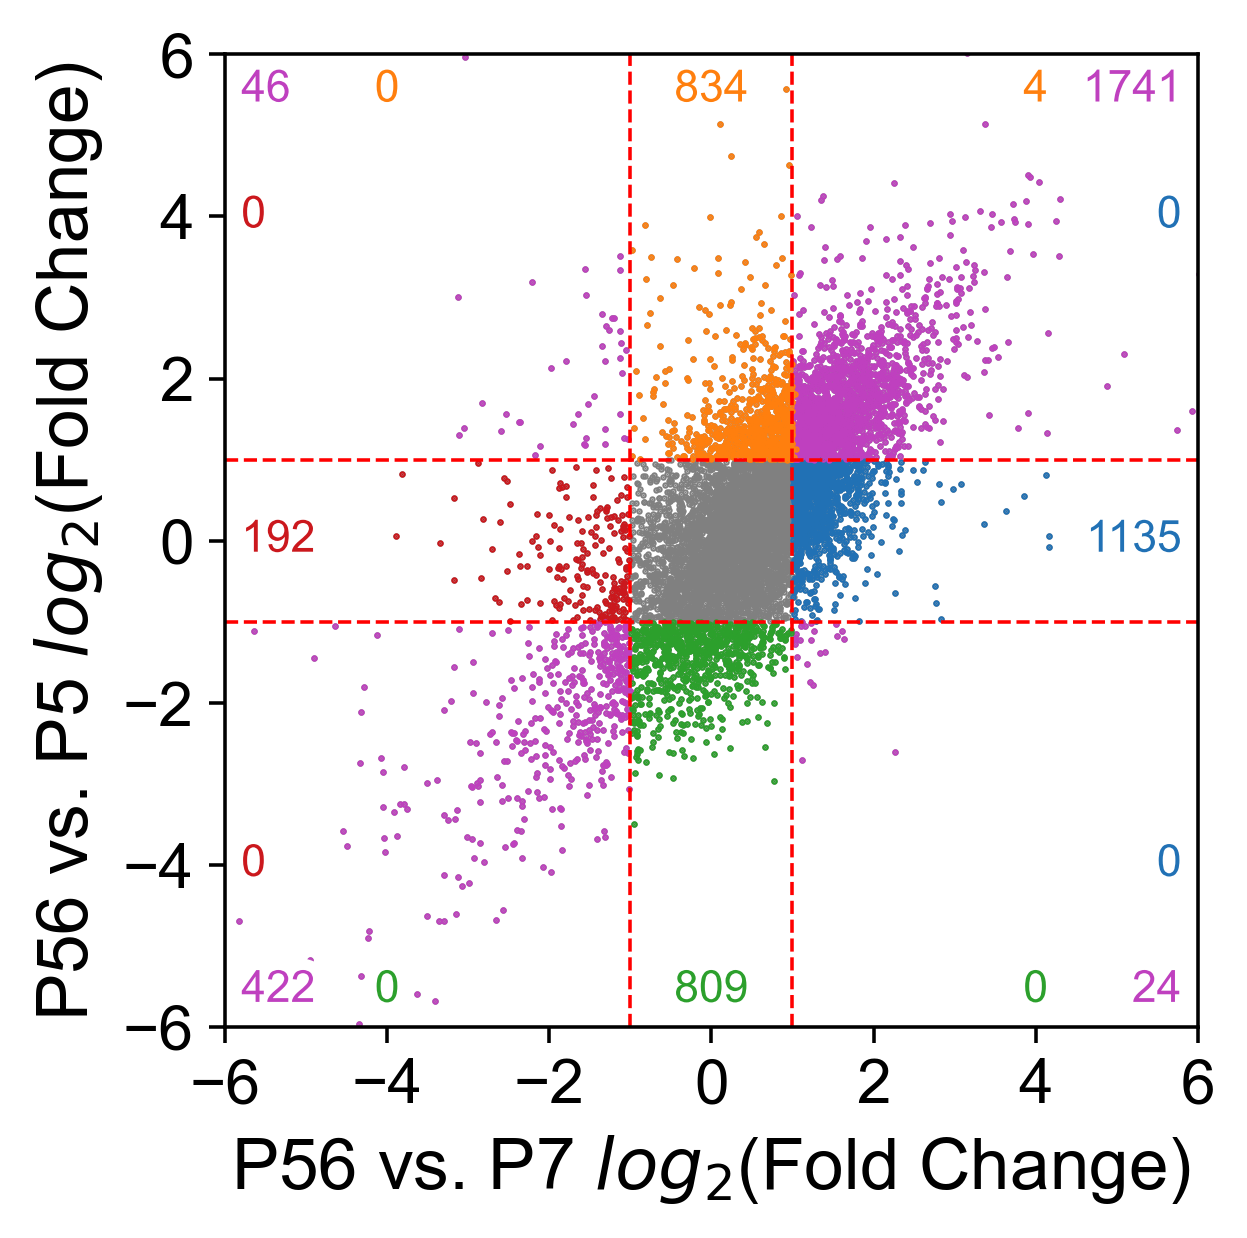

In [25]:
make_type_scatter([p56_p7_fold_changes], [p56_p5_fold_changes], [[p7_p56_blacklist], [p7_p5_blacklist], [p5_p56_blacklist]], 'P56 vs. P7 $log_2$(Fold Change)', 'P56 vs. P5 $log_2$(Fold Change)', 'P56vsP7-P56vsP5.svg', [DE_up_genes_dict['P56 vs. P7']], [DE_down_genes_dict['P56 vs. P7']], [DE_up_genes_dict['P56 vs. P5']], [DE_down_genes_dict['P56 vs. P5']], xlims=(-6,6), ylims=(-6,6), LFC_thresh=1, test_genes=[], title='')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.71it/s]


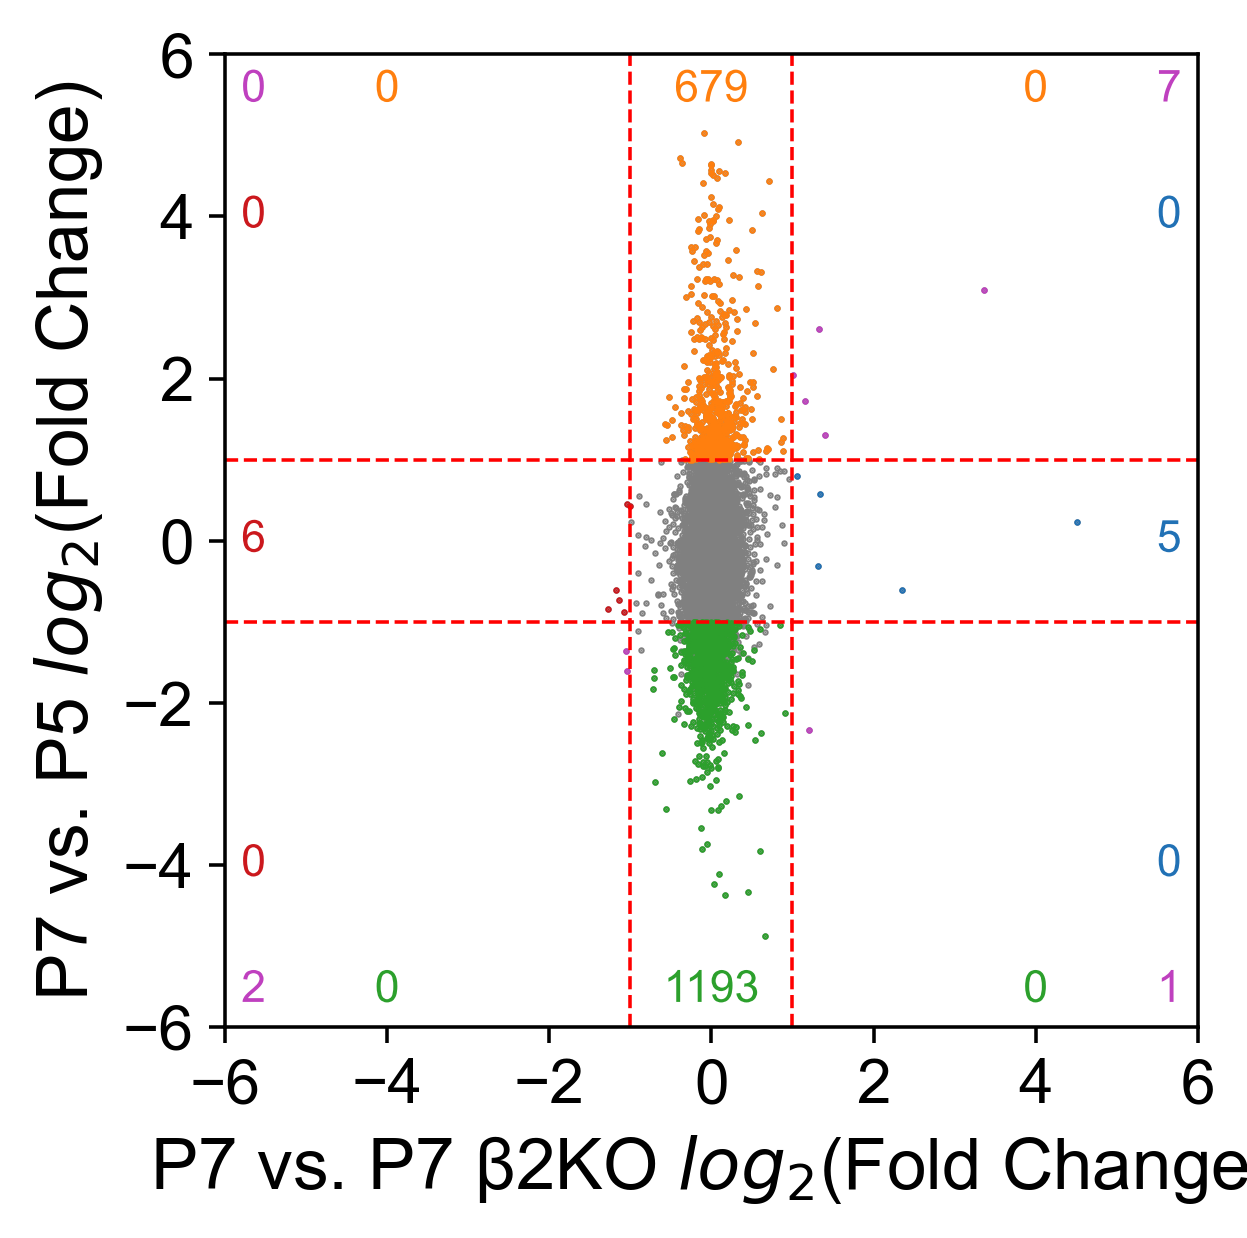

In [26]:
make_type_scatter([p7_p7b2_fold_changes], [p7_p5_fold_changes], [[p7_p56_blacklist], [p7_p5_blacklist], [p5_p56_blacklist]], 'P7 vs. P7 β2KO $log_2$(Fold Change)', 'P7 vs. P5 $log_2$(Fold Change)', 'P7vsP7b2-P7vsP5.svg', [DE_up_genes_dict['P7 vs. P7b2']], [DE_down_genes_dict['P7 vs. P7b2']], [DE_up_genes_dict['P7 vs. P5']], [DE_down_genes_dict['P7 vs. P5']], xlims=(-6,6), ylims=(-6,6), LFC_thresh=1, test_genes=[], title='')

In [27]:
universal_blacklist_names = [gene_names[x] for x in p7_p56_blacklist + p7_p5_blacklist + p5_p56_blacklist]

In [28]:
DE_up_genes_filtered_dict = {}
DE_down_genes_filtered_dict = {}
DE_genes_filtered_dict = {}
LFC_cutoff_genes_filtered_dict = {}
for i in tqdm(comparisons):
    up_filtered = [x for x in DE_up_genes_dict[i] if x not in universal_blacklist_names]
    down_filtered = [x for x in DE_down_genes_dict[i] if x not in universal_blacklist_names]
    LFC_cutoff_filtered = [x for x in LFC_cutoff_genes_dict[i] if x not in universal_blacklist_names]
    DE_up_genes_filtered_dict[i] = up_filtered
    DE_down_genes_filtered_dict[i] = down_filtered
    DE_genes_filtered_dict[i] = up_filtered + down_filtered
    LFC_cutoff_genes_filtered_dict[i] = LFC_cutoff_filtered

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


In [29]:
for i in comparisons:
    print('-----------')
    print(i)
    print(len(LFC_cutoff_genes_filtered_dict[i]))
    print(len(DE_genes_filtered_dict[i]))
print('-----------')

-----------
P56 vs. P5
3880
3880
-----------
P56 vs. P7
3577
3560
-----------
P7 vs. P5
2229
1882
-----------
P7 vs. P7b2
21
21
-----------


In [30]:
P56_P5_overlap_P56_P7 = 0
for i in DE_genes_filtered_dict['P56 vs. P5']:
    if i in DE_genes_filtered_dict['P56 vs. P7']:
        P56_P5_overlap_P56_P7 += 1
print(P56_P5_overlap_P56_P7)

2233


In [31]:
len(gene_names)

15976

In [33]:
# Hypergeometric Test
K = len(DE_genes_filtered_dict['P56 vs. P5'])
k = P56_P5_overlap_P56_P7
N = len(LFC_cutoff_genes_filtered_dict['P56 vs. P5'])+len(LFC_cutoff_genes_filtered_dict['P56 vs. P7'])#len(gene_names)
n = len(DE_genes_filtered_dict['P56 vs. P7'])
num = math.comb(K, k)*math.comb(N-K, n-k)
denom = math.comb(N, n)
print(num/denom)

9.88973510586089e-71


# Inter-Replicate Changes

In [35]:
comparisons_rep = ["P7rep1 vs. P7rep2", "P7b2rep1 vs. P7b2rep2"]

In [36]:
fold_changes_dict_rep = {"P7rep1 vs. P7rep2": p7rep1_p7rep2_fold_changes,
                         "P7b2rep1 vs. P7b2rep2": p7b2rep1_p7b2rep2_fold_changes}

In [37]:
LFC_cutoff_genes_dict_rep = {}
LFC_cutoff_gene_FCs_dict_rep = {}
for i in tqdm(comparisons_rep):
    fcs = fold_changes_dict_rep[i]
    cutoff_indices = [x for x in range(len(fcs)) if abs(np.log2(fcs[x])) > 1]
    cutoff_genes = [gene_names[x] for x in cutoff_indices]
    cutoff_gene_FCs = [fcs[x] for x in cutoff_indices]
    LFC_cutoff_genes_dict_rep[i] = cutoff_genes
    LFC_cutoff_gene_FCs_dict_rep[i] = cutoff_gene_FCs

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22.15it/s]


In [39]:
adata_pairing_dict_rep = {"P7rep1 vs. P7rep2": [p7_adata[p7_adata.obs['Batch'] == 'Batch1'], p7_adata[p7_adata.obs['Batch'] == 'Batch2']],
                          "P7b2rep1 vs. P7b2rep2": [p7b2_adata[p7b2_adata.obs['Batch'].isin(['Batch1', 'Batch2'])], p7b2_adata[p7b2_adata.obs['Batch'] == 'Batch1_2']]}

In [40]:
adata_combined_dict_rep = {}
for i in tqdm(comparisons_rep):
    adata_1 = adata_pairing_dict_rep[i][0].copy()
    adata_2 = adata_pairing_dict_rep[i][1].copy()
    
    combined_adata = ad.concat([adata_1, adata_2], label='Condition', keys=[i.split(' ')[0], i.split(' ')[2]])
    combined_adata.obs_names_make_unique()
    
    sc.tl.rank_genes_groups(combined_adata, groupby='Condition', method='wilcoxon', mask_var=combined_adata.raw.var_names.isin(LFC_cutoff_genes_dict_rep[i]))
    
    adata_combined_dict_rep[i] = combined_adata

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [03:41<00:00, 110.57s/it]


In [41]:
DE_up_genes_dict_rep = {}
DE_down_genes_dict_rep = {}
for i in tqdm(comparisons_rep):
    df = sc.get.rank_genes_groups_df(adata_combined_dict_rep[i], i.split(' ')[0], pval_cutoff=0.05)
    df = df[df.names.isin(gene_names)]
    up_genes = []
    down_genes = []
    for j in df.names:
        fc_index = gene_names.index(j)
        if np.log2(fold_changes_dict_rep[i][fc_index]) > 1:
            up_genes.append(j)
        elif np.log2(fold_changes_dict_rep[i][fc_index]) < -1:
            down_genes.append(j)
    DE_up_genes_dict_rep[i] = up_genes
    DE_down_genes_dict_rep[i] = down_genes

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


In [42]:
DE_up_genes_filtered_dict_rep = {}
DE_down_genes_filtered_dict_rep = {}
DE_genes_filtered_dict_rep = {}
LFC_cutoff_genes_filtered_dict_rep = {}
for i in tqdm(comparisons_rep):
    up_filtered = [x for x in DE_up_genes_dict_rep[i] if x not in universal_blacklist_names]
    down_filtered = [x for x in DE_down_genes_dict_rep[i] if x not in universal_blacklist_names]
    LFC_cutoff_filtered = [x for x in LFC_cutoff_genes_dict_rep[i] if x not in universal_blacklist_names]
    DE_up_genes_filtered_dict_rep[i] = up_filtered
    DE_down_genes_filtered_dict_rep[i] = down_filtered
    DE_genes_filtered_dict_rep[i] = up_filtered + down_filtered
    LFC_cutoff_genes_filtered_dict_rep[i] = LFC_cutoff_filtered

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 221.11it/s]


In [43]:
for i in comparisons_rep:
    print('-----------')
    print(i)
    print(len(LFC_cutoff_genes_filtered_dict_rep[i]))
    print(len(DE_genes_filtered_dict_rep[i]))
print('-----------')

-----------
P7rep1 vs. P7rep2
0
0
-----------
P7b2rep1 vs. P7b2rep2
7
7
-----------


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


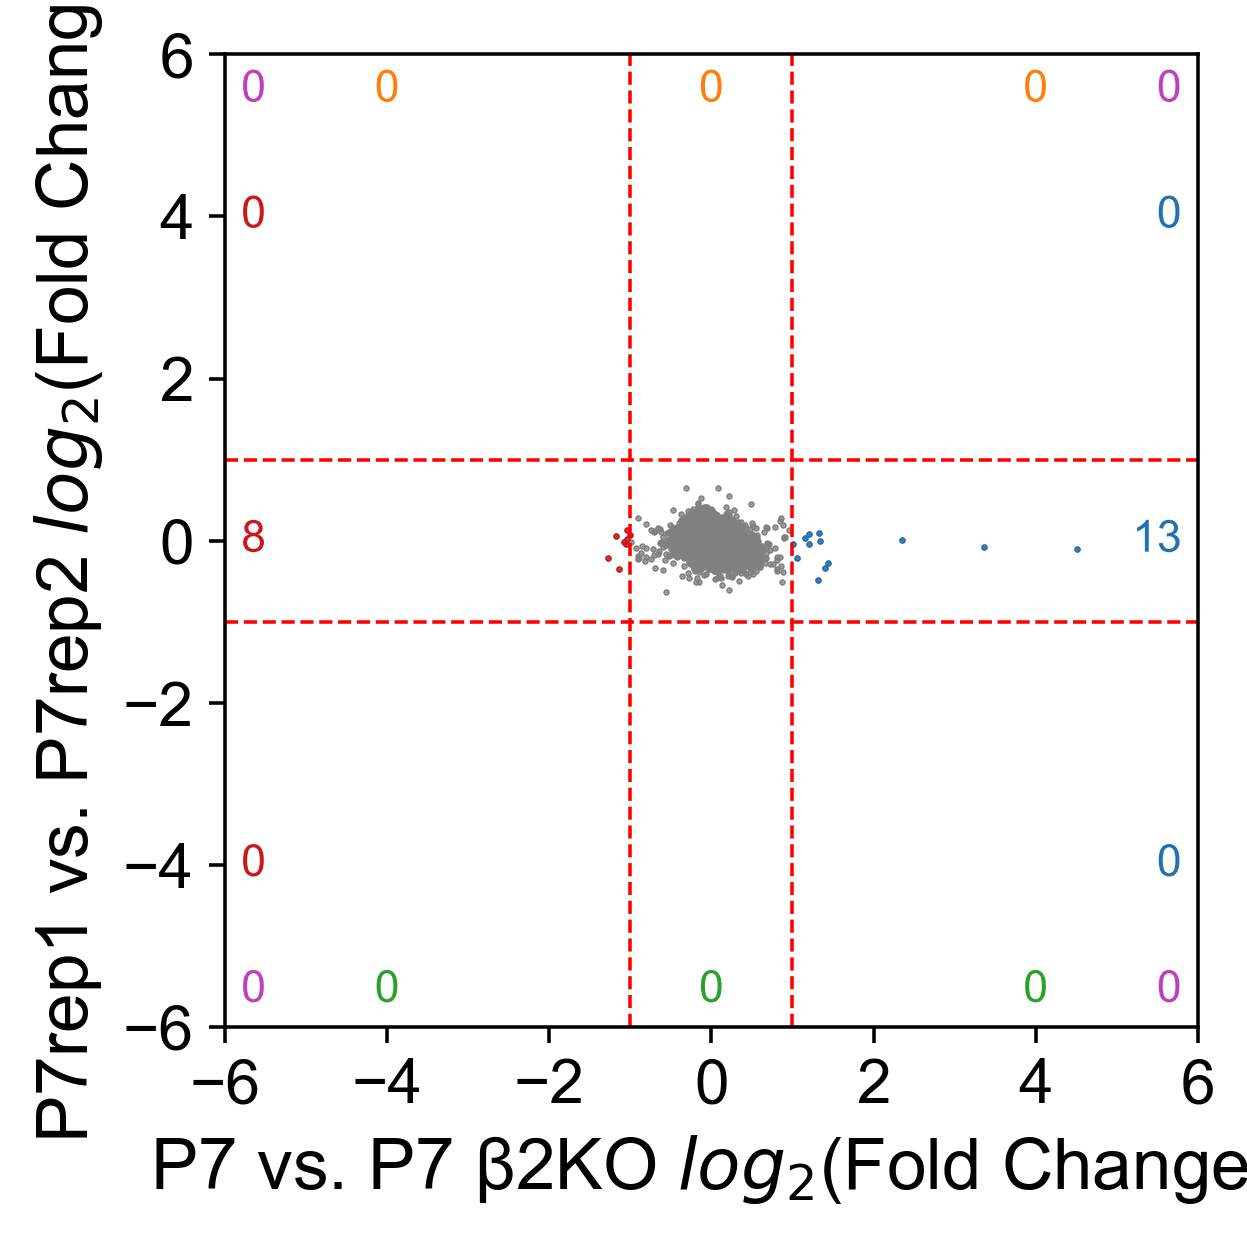

In [44]:
make_type_scatter([p7_p7b2_fold_changes], [p7rep1_p7rep2_fold_changes], [[p7_p56_blacklist], [p7_p5_blacklist], [p5_p56_blacklist]], 'P7 vs. P7 β2KO $log_2$(Fold Change)', 'P7rep1 vs. P7rep2 $log_2$(Fold Change)', 'P7vsP7b2-P7rep1vsP7rep2.svg', [DE_up_genes_dict['P7 vs. P7b2']], [DE_down_genes_dict['P7 vs. P7b2']], [DE_up_genes_dict_rep['P7rep1 vs. P7rep2']], [DE_down_genes_dict_rep['P7rep1 vs. P7rep2']], xlims=(-6,6), ylims=(-6,6), LFC_thresh=1, test_genes=[], title='')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


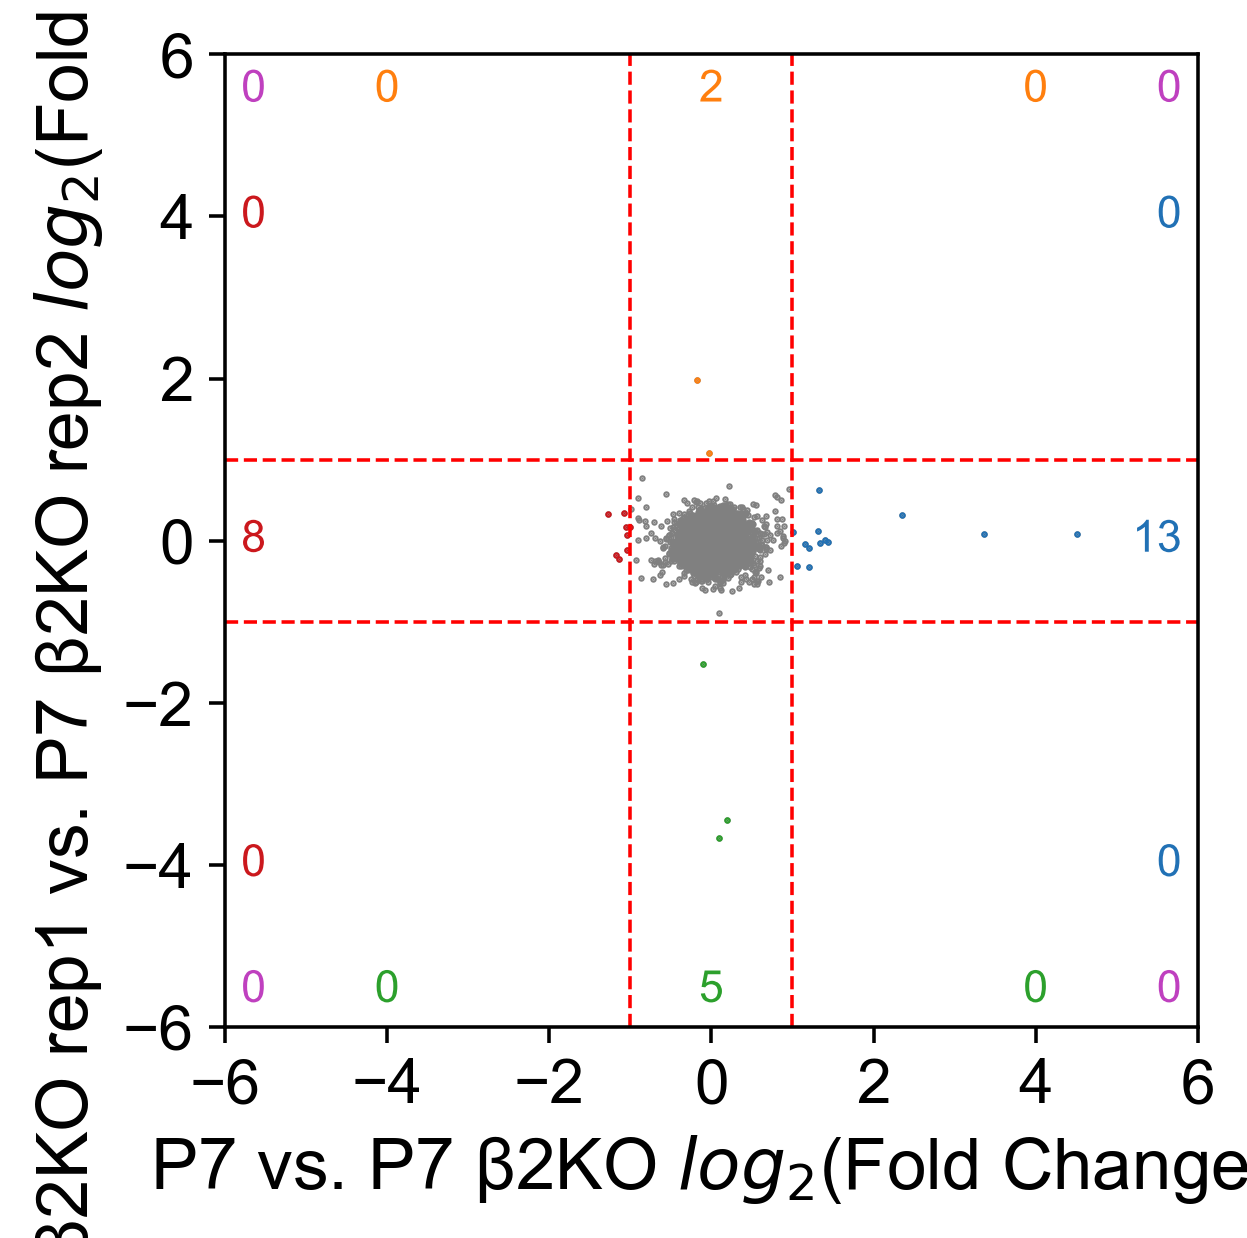

In [45]:
make_type_scatter([p7_p7b2_fold_changes], [p7b2rep1_p7b2rep2_fold_changes], [[p7_p56_blacklist], [p7_p5_blacklist], [p5_p56_blacklist]], 'P7 vs. P7 β2KO $log_2$(Fold Change)', 'P7 β2KO rep1 vs. P7 β2KO rep2 $log_2$(Fold Change)', 'P7vsP7b2-P7b2rep1vsP7b2rep2.svg', [DE_up_genes_dict['P7 vs. P7b2']], [DE_down_genes_dict['P7 vs. P7b2']], [DE_up_genes_dict_rep['P7b2rep1 vs. P7b2rep2']], [DE_down_genes_dict_rep['P7b2rep1 vs. P7b2rep2']], xlims=(-6,6), ylims=(-6,6), LFC_thresh=1, test_genes=[], title='')